# Pipeline

## Introduction

In this notebook, I will use the knowledge gained from the Exploratory Data Analsysis (EDA) and build an automated preprocessing pipeline and various models.

Summarizing, the problem we found were:
1. **Mismeasurement**: presence of non-positive data points;
2. **Skewed dataset**: different scales and dsitributions;
3. **Outliers**: high skewness and kurtosis values indicated the presence of outliers in the dataset;

Our objective is to build a Pipeline, which can solve the latter problems. We will then compare various models, used to predict the target variable price, respectively Linear Regression, XGBoost Regression and Ridge Regression, which will be tuned and optimized.

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import optuna

c:\Users\len\anaconda3\envs\Machine_Learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
diamonds = pd.read_csv("https://raw.githubusercontent.com/xtreamsrl/xtream-ai-assignment-engineer/main/datasets/diamonds/diamonds.csv")
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


## PreProcess Pipelines

In this section, I will discuss the 4 different pipelines, which I have developed and tested in the dataset.

**Base Pipeline**

Firstly, we are going to remove the errors and the mismeasurment, respectively the non-positive data points. Secondly, we are going to perform a correlation analysis, removing very similar features between themselves, and least correlated features with our target variable price. Then, to address the problem of the scale, we will log transform the price and standardize each column to make it in the interval [-1,1]. The latter operation is done by performing:

$\hspace{70mm} X' = \frac{X - \bar{X}}{\sigma_{X}} \hspace{5mm} \forall X \hspace{1mm}\text{feature}$

Lastly, the cateorical variables will be hot-encoded and we are ready to employ our model. It is important to note that we cannot perform the same analysis for categorical variables because they have no numerical value; therefore, to exclude some categorical variables, use violins and scatter plots. I'll keep them here

**Isolation Forest Pipeline**

Here, I use the Isolation Forest Algorithm to remove the outliers. It will be added to the base pipeline between error removal and transformation, with categorical variables already encoded. I opted to use it before standardizing since otherwise it could deceive and not remove what we require.

**PCA Pipeline**

This is also an enrichment of the base pipeline. I will add PCA at the end of everything to reduce the dimensionality of the dataset. I do not expect to work well, given the reduced dimensionality of just 5000. But, for the sake of completeness and to try also this technique, I will employ it and test it.

**Isolation Forest and PCA Pipeline**

Here, I will merge both techniques mentioned before and employ them together.



### Utils

In [6]:
# Given a dataset, let us distinguish numerical and categorical variables
def feature_type(data):
    categorical = data.select_dtypes(include=['object']).columns.tolist()
    numerical = data.select_dtypes(include=['number']).columns.tolist()
    return categorical,numerical

# Let us understand which variables to remove based on correlation
def correlated_features(data):
    # We will see the linear correlation with the target variable price
    corr_dict = dict(np.abs(data.corr()['price']))
    # Let us remove price
    del corr_dict['price']
    # Now let us keep track of the features to remove starting with the least correlated ones
    # without loss of generality we will remove all variables with correlation below 0.05 
    delete_col = [k for k, v in corr_dict.items() if v < 0.05]
    # Now let us remove variables with analogus values so similar correlation
    for ix, keys in enumerate(list(corr_dict.keys()),1):
        if keys in delete_col:
            continue
        else:
            for keys2 in list(corr_dict.keys())[ix:]:
                # If variables are very correlated between them selves I remove one of them
                # I choose a similar correlation which differs maximum of 0.01
                if np.abs(corr_dict[keys] - corr_dict[keys2]) < 0.01 :
                    delete_col.append(keys)
                    break
    return delete_col
# Let us save the variable which remain after the elimination
def remaining_var(data):
    delete = correlated_features(data)
    cat,num = feature_type(data)
    rem_num = [feature for feature in num if feature not in delete]
    rem_cat = [feature for feature in cat if feature not in delete]
    return rem_cat,rem_num

Here I am re-defining all the process we will need for our pipeline since I would like to process both features and labels in the same pipeline and It is desirable to keep pandas format.

In [7]:
# Class to drop columns in the dataset
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        # Assert the columns is a list for simplicity
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self,X, y = None):
        return self
    def transform(self,X):
        # Drop columns
        return X.drop(columns = self.columns)
# Class to remove rows originated by errors in the dataset   
class RemoveErrorsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        # Assert the columns is a list for simplicity
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self,X, y = None):
        return self
    def transform(self,X):
        X = X.copy()
        for col in self.columns:
            # All the variables should be positive given their meaning
            X = X[X[col]>0]
        return X      

# you can log transform chosen columns (in our case it will be price, the label)
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        # Assert the columns is a list for simplicity
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            # Log transformation of a column
            X[col] = np.log1p(X[col])
        return X

# One hot encode categorical variables  
class ModifiedOnehotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        # Assert the columns is a list for simplicity
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self,X,y= None):
        return self
    def transform(self,X):
        X = X.copy()
        # Use get_dummies function to create dummy variables for each value
        # for every categorical value
        X_encod = pd.get_dummies(X, columns= self.columns, drop_first=True)
        return X_encod

# Scale numerical columns based on mean and standard deviation   
class ModifiedStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        # Assert the columns is a list for simplicity
        assert isinstance(columns,list)
        self.columns = columns
    def fit(self,X,y= None):
        return self
    def transform(self,X):
        X = X.copy()
        for col in self.columns:
            # Standardize with mean and standard deviation of the column
            X[col] = (X[col] - X[col].mean()) / X[col].std()
        return X

# Remove outliers
class IsolationForestTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.model = IsolationForest()  
    def fit(self,X,y=None):
        self.model.fit(X)
        return self
    def transform(self,X):
        X = X.copy()
        pred = self.model.predict(X)
        # Take only the one which were classified as not outliers
        X = X[pred == 1]  
        return X
    
class PCATransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        # Keep 95% of varinace
        self.model = PCA(n_components=0.95)
        self.index = None
    def fit(self,X,y = None):
        # I have to transpose since PCA works on the dimensionality reduction of columns
        self.model.fit(X.T)
        return self
    def transform(self,X):
        X_tr = X.T
        reduced_df = self.model.transform(X_tr)
        index = [f'PC{i+1}' for i in range(reduced_df.shape[1])]
        self.index = index
        # Return a dataset with modified rows
        reduced_df = pd.DataFrame(reduced_df.T, columns= X.columns ,index= self.index)
        return reduced_df

### Base Pipeline 

In [8]:
numeric_transformer = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds))),
                                        ('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor = Pipeline(steps=[('preprocess_num',numeric_transformer),
                               ('preprocessor_cat',cat_transformer)])


C:\Users\len\AppData\Local\Temp\ipykernel_16124\3395825247.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


### PreProcess Pipeline with Isolation Forest

In [9]:
numeric_transformer1 = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds)))])
numeric_transformer2 = Pipeline(steps = [('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor_iso = Pipeline(steps=[('preprocess_num1',numeric_transformer1),
                               ('preprocessor_cat',cat_transformer),
                               ('outlier remove', IsolationForestTransformer()),
                               ('preprocess_num2',numeric_transformer2)])

C:\Users\len\AppData\Local\Temp\ipykernel_16124\3395825247.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


### Preprocess Pipeline with PCA

In [10]:
numeric_transformer = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds))),
                                        ('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor_pca = Pipeline(steps=[('preprocess_num',numeric_transformer),
                               ('preprocessor_cat',cat_transformer),
                               ('dimensionality_reduction',PCATransformer())])

C:\Users\len\AppData\Local\Temp\ipykernel_16124\3395825247.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


### Preprocess pipeline with PCA and Isolation Forest

In [11]:
numeric_transformer1 = Pipeline(steps = [('Error_remove',RemoveErrorsTransformer(feature_type(diamonds)[1])),
                                        ('Drop Erroneus',DropColumns(correlated_features(diamonds)))])
numeric_transformer2 = Pipeline(steps = [('log_transform_price', LogTransformer(columns=['price'])),
                                        ('scaler',ModifiedStandardScaler(remaining_var(diamonds)[1]))])
cat_transformer = Pipeline(steps= [('encoder', ModifiedOnehotEncoder(feature_type(diamonds)[0]))])

preprocessor_iso_pca = Pipeline(steps=[('preprocess_num1',numeric_transformer1),
                               ('preprocessor_cat',cat_transformer),
                               ('outlier remove', IsolationForestTransformer()),
                               ('preprocess_num2',numeric_transformer2),
                               ('dimensionality_reduction',PCATransformer())])

C:\Users\len\AppData\Local\Temp\ipykernel_16124\3395825247.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_dict = dict(np.abs(data.corr()['price']))


## Final Pipeline with model incorporation

Here, I will put togheter, the preprocess pipeline and the model with hyperparaemter tuning with a way to save their performances.

In [12]:
class ModelOptimizer:
    # Initialization
    def __init__(self):
        # 3 different models
        self.models = ['LinearRegression', 'XGBRegressor', 'Ridge']
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.pred = None
        self.model_name = None

    # In order to use optuna library I have to define an objective function
    def objective(self, trial: optuna.trial.Trial, X_train, X_test, y_train, y_test, model_available) -> float:
        
        if model_available == 'LinearRegression':
            # Parameters LinearRegression
            param = {
                'copy_X': True,
                'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
                'n_jobs': None,
                'positive': False
            }
            model = LinearRegression(**param)
        
        elif model_available == 'XGBRegressor':
            # Parameters XGBRegressor
            param = {
                'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
                'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
                'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.7]),
                'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
                'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 9),
                'random_state': 42,
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'enable_categorical': True
            }
            model = XGBRegressor(**param)
        
        elif model_available == 'Ridge':
            # Parameters Ridge Regression
            param = {
                'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
                'copy_X': True,
                'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
                'max_iter': None,
                'positive': False,
                'random_state': 123,
                'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
                'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
            }
            model = Ridge(**param)
        
        else:
            raise IndexError(f"The only models in this server are {self.models}, use one of these or contact the creator")
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        return mae

    def full_pipeline(self, preprocess, data, model_available, model_name):
        assert isinstance(model_name, str)
        self.model_name = model_name
        if model_available not in self.models:
            raise IndexError(f"The only models in this server are {self.models}, use one of these or contact the creator")
        
        y = data['price']
        X = data.drop(columns=['price'])
        # Split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        data_train = self.X_train.assign(price=self.y_train)
        data_test = self.X_test.assign(price=y_test)
        
        # Fit separately for traing and testing
        preprocess.fit(data_train)
        data_processed_train = preprocess.transform(data_train)
        preprocess.fit(data_test)
        data_processed_test = preprocess.transform(data_test)
        
        # Preprocess separetly training and testing
        self.X_train,self.y_train = data_processed_train.drop(columns=['price']), data_processed_train['price']
        self.X_test, self.y_test = data_processed_test.drop(columns=['price']), data_processed_test['price']
        
        # Hyperparamter optimization
        study = optuna.create_study(direction='minimize', study_name=f'Diamonds {model_available}')
        study.optimize(lambda trial: self.objective(trial, self.X_train, self.X_test, self.y_train, self.y_test, model_available), n_trials=100)
        
        # Access the optimized model
        if model_available == 'LinearRegression':
            model = LinearRegression(**study.best_params)
        elif model_available == 'XGBRegressor':
            model = XGBRegressor(**study.best_params)
        elif model_available == 'Ridge':
            model = Ridge(**study.best_params)
        
        # Do final fitting and prediction
        model.fit(self.X_train, self.y_train)
        self.pred = model.predict(self.X_test)
        
        # Save stats
        stats = pd.DataFrame(np.zeros((1, 2)), index=[model_name], columns=['MAE', 'R2'])
        stats['MAE'][model_name] = round(mean_absolute_error(self.y_test, self.pred), 4)
        stats['R2'][model_name] = round(r2_score(self.y_test, self.pred), 4)
        # Put it in transpose
        stats = stats.T
    
        return stats
    # Plotting regression Line
    def plot(self):
        plt.plot(self.y_test, self.pred, '.')
        plt.plot(self.y_test, self.y_test, linewidth=3, c='black')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(self.model_name + ' performances')
        plt.show()



## Statistics recording

I will create a dataset to record all mean absolute errors and R2 score to keep the performances of all employed models

In [13]:
stats = pd.DataFrame(np.zeros((2,1)),columns=['col'],index = ['MAE','R2'])

## Linear Model

### Base Pipeline

In [15]:
optim = ModelOptimizer()
model_name = 'Linear Regression'
linear_reg = optim.full_pipeline(preprocessor,diamonds,'LinearRegression',model_name)

[I 2024-07-02 11:20:24,340] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-02 11:20:24,468] Trial 0 finished with value: 0.13046866762157458 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.13046866762157458.
[I 2024-07-02 11:20:24,472] Trial 1 finished with value: 0.14022568116673825 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.13046866762157458.
[I 2024-07-02 11:20:24,484] Trial 2 finished with value: 0.13046866762157458 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.13046866762157458.
[I 2024-07-02 11:20:24,490] Trial 3 finished with value: 0.13046866762157458 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.13046866762157458.
[I 2024-07-02 11:20:24,499] Trial 4 finished with value: 0.14022568116673825 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.13046866762157458.
[I 2024-07-02 11:20:24,508] Trial 5 finished with value: 0.130468667

In [16]:
linear_reg

,Linear Regression
MAE,0.1305
R2,0.9681


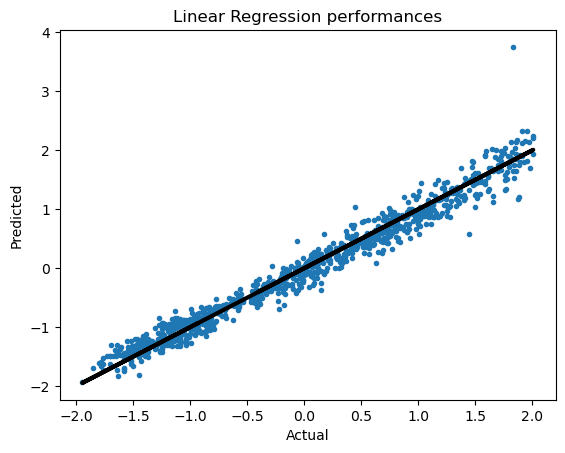

In [17]:
optim.plot()

In [18]:
# Add to dataset
stats[model_name] = linear_reg

###  Isolation Forest Pipeline

In [19]:
optim = ModelOptimizer()
model_name = 'Linear Regression Isolation Forest'
linear_regr_iso = optim.full_pipeline(preprocessor_iso,diamonds,'LinearRegression',model_name)

[I 2024-07-02 11:20:37,041] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-02 11:20:37,043] Trial 0 finished with value: 0.1514649127436412 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.1514649127436412.
[I 2024-07-02 11:20:37,043] Trial 1 finished with value: 0.1514649127436412 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.1514649127436412.
[I 2024-07-02 11:20:37,058] Trial 2 finished with value: 0.14011137811987362 and parameters: {'fit_intercept': True}. Best is trial 2 with value: 0.14011137811987362.
[I 2024-07-02 11:20:37,066] Trial 3 finished with value: 0.1514649127436412 and parameters: {'fit_intercept': False}. Best is trial 2 with value: 0.14011137811987362.
[I 2024-07-02 11:20:37,076] Trial 4 finished with value: 0.14011137811987362 and parameters: {'fit_intercept': True}. Best is trial 2 with value: 0.14011137811987362.
[I 2024-07-02 11:20:37,079] Trial 5 finished with value: 0.1514649127436

In [20]:
linear_regr_iso

,Linear Regression Isolation Forest
MAE,0.1401
R2,0.9670


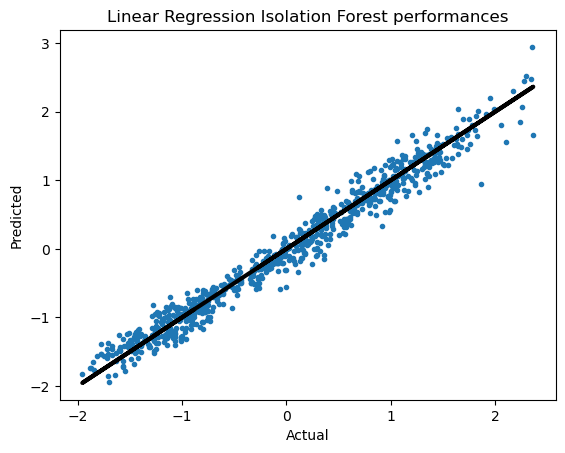

In [21]:
optim.plot()

In [22]:
# Add to dataset
stats[model_name] = linear_regr_iso

### PCA Pipeline

In [23]:
optim = ModelOptimizer()
model_name = 'Linear Regression PCA'
linear_regr_pca = optim.full_pipeline(preprocessor_pca,diamonds,'LinearRegression',model_name)

[I 2024-07-02 11:20:42,619] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-02 11:20:42,624] Trial 0 finished with value: 0.3825267275928536 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-02 11:20:42,628] Trial 1 finished with value: 0.3825267275928536 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-02 11:20:42,631] Trial 2 finished with value: 0.4155037210917021 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-02 11:20:42,637] Trial 3 finished with value: 0.3825267275928536 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-02 11:20:42,642] Trial 4 finished with value: 0.3825267275928536 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 0.3825267275928536.
[I 2024-07-02 11:20:42,645] Trial 5 finished with value: 0.3825267275928536 

In [24]:
linear_regr_pca

,Linear Regression PCA
MAE,0.3825
R2,0.9950


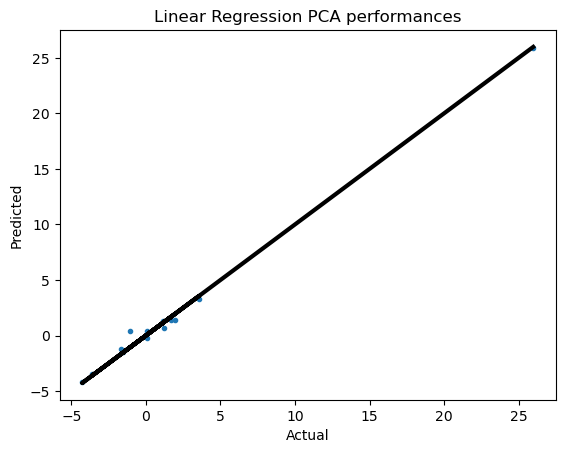

In [127]:
optim.plot()

In [25]:
# Add to dataset
stats[model_name] = linear_regr_pca

### Isolation Forest and PCA Pipeline

In [26]:
optim = ModelOptimizer()
model_name = 'Linear Regression Isolation Forest and PCA'
linear_regr_iso_pca = optim.full_pipeline(preprocessor_iso_pca,diamonds,'LinearRegression',model_name)

[I 2024-07-02 11:20:54,342] A new study created in memory with name: Diamonds LinearRegression
[I 2024-07-02 11:20:54,359] Trial 0 finished with value: 2.7548964499941544 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 2.7548964499941544.
[I 2024-07-02 11:20:54,364] Trial 1 finished with value: 2.7548964499941544 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 2.7548964499941544.
[I 2024-07-02 11:20:54,369] Trial 2 finished with value: 0.27785316015058564 and parameters: {'fit_intercept': False}. Best is trial 2 with value: 0.27785316015058564.
[I 2024-07-02 11:20:54,376] Trial 3 finished with value: 2.7548964499941544 and parameters: {'fit_intercept': True}. Best is trial 2 with value: 0.27785316015058564.
[I 2024-07-02 11:20:54,382] Trial 4 finished with value: 0.27785316015058564 and parameters: {'fit_intercept': False}. Best is trial 2 with value: 0.27785316015058564.
[I 2024-07-02 11:20:54,385] Trial 5 finished with value: 2.75489644999415

In [27]:
linear_regr_iso_pca

,Linear Regression Isolation Forest and PCA
MAE,0.2779
R2,0.9973


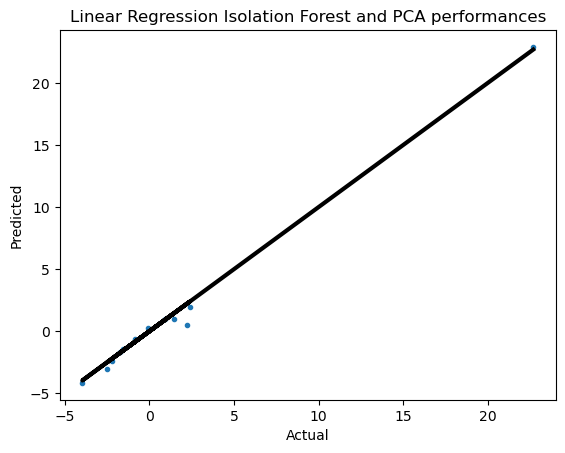

In [131]:
optim.plot()

In [28]:
# Add to dataset
stats[model_name] = linear_regr_iso_pca

## XGBoost Pipeline

### Base Pipeline

In [29]:
optim = ModelOptimizer()
model_name = 'XGBoost Regression'
xgb_regr = optim.full_pipeline(preprocessor,diamonds,'XGBRegressor',model_name)

[I 2024-07-02 11:20:58,148] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-02 11:20:58,557] Trial 0 finished with value: 0.13683577731741706 and parameters: {'lambda': 0.0014004152231271595, 'alpha': 1.360143415058456e-07, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.040631366575319315, 'n_estimators': 395, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 0 with value: 0.13683577731741706.
[I 2024-07-02 11:20:59,472] Trial 1 finished with value: 0.8381760530663555 and parameters: {'lambda': 7.283495331485401e-08, 'alpha': 0.16111058720653143, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 4.478101230636376e-05, 'n_estimators': 684, 'max_depth': 8, 'min_child_weight': 9}. Best is trial 0 with value: 0.13683577731741706.
[I 2024-07-02 11:21:01,125] Trial 2 finished with value: 0.1256075137115718 and parameters: {'lambda': 0.024918066227721233, 'alpha': 0.00016345738623374645, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learnin

In [30]:
xgb_regr

,XGBoost Regression
MAE,0.1123
R2,0.9765


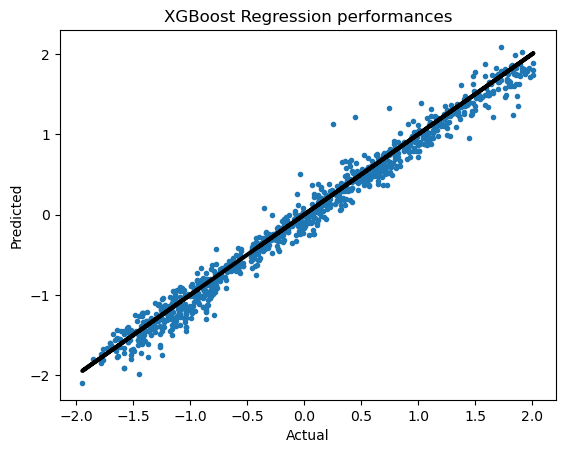

In [135]:
optim.plot()

In [31]:
# Add to dataset
stats[model_name] = xgb_regr

### Isolation Forest Pipeline

In [32]:
optim = ModelOptimizer()
model_name = 'XGBoost Regression Isolation Forest'
xgb_regr_iso = optim.full_pipeline(preprocessor_iso,diamonds,'XGBRegressor',model_name)

[I 2024-07-02 11:22:21,843] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-02 11:22:22,340] Trial 0 finished with value: 0.16211200503681744 and parameters: {'lambda': 2.8187556963892585e-07, 'alpha': 0.00016400902202822187, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.45434479466760874, 'n_estimators': 444, 'max_depth': 9, 'min_child_weight': 9}. Best is trial 0 with value: 0.16211200503681744.
[I 2024-07-02 11:22:22,820] Trial 1 finished with value: 0.13225399389796047 and parameters: {'lambda': 1.830489632090554e-08, 'alpha': 0.0024092275531416097, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.06013512559482452, 'n_estimators': 592, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 1 with value: 0.13225399389796047.
[I 2024-07-02 11:22:23,007] Trial 2 finished with value: 0.23673044223049333 and parameters: {'lambda': 7.25598416434624e-07, 'alpha': 0.023542528898255834, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learni

In [33]:
xgb_regr_iso

,XGBoost Regression Isolation Forest
MAE,0.1328
R2,0.9687


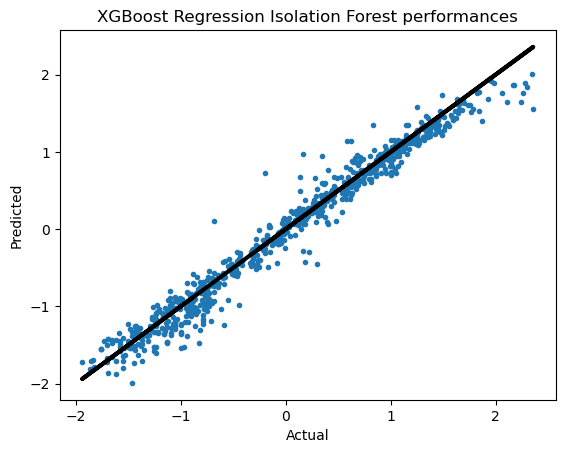

In [139]:
optim.plot()

In [34]:
# Add to dataset
stats[model_name] = xgb_regr_iso

### PCA Pipeline

In [35]:
optim = ModelOptimizer()
model_name = 'XGBoost Regression PCA'
xgb_regr_pca = optim.full_pipeline(preprocessor_pca,diamonds,'XGBRegressor',model_name)

[I 2024-07-02 11:23:31,154] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-02 11:23:31,435] Trial 0 finished with value: 5.6650990427036385 and parameters: {'lambda': 0.0007834785122242352, 'alpha': 0.00010332032110650859, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.0007898365115151037, 'n_estimators': 866, 'max_depth': 5, 'min_child_weight': 6}. Best is trial 0 with value: 5.6650990427036385.
[I 2024-07-02 11:23:31,652] Trial 1 finished with value: 4.464876474750384 and parameters: {'lambda': 0.7037954044622545, 'alpha': 1.4110649600465952e-06, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.00028125832414333, 'n_estimators': 531, 'max_depth': 8, 'min_child_weight': 5}. Best is trial 1 with value: 4.464876474750384.
[I 2024-07-02 11:23:31,918] Trial 2 finished with value: 4.725751461398944 and parameters: {'lambda': 1.815405524003052e-05, 'alpha': 0.0010767173349026588, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate

In [36]:
xgb_regr_pca

,XGBoost Regression PCA
MAE,2.3494
R2,0.6955


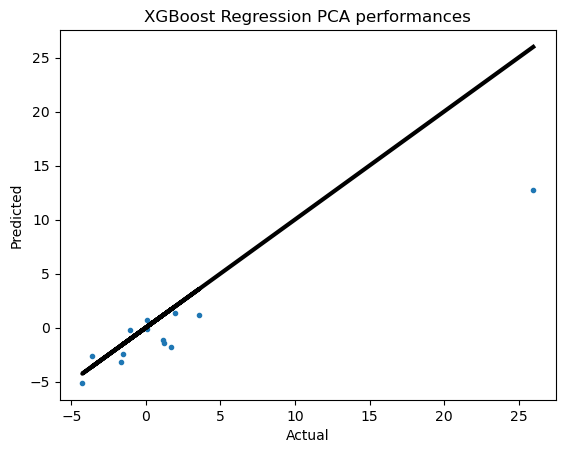

In [37]:
optim.plot()

In [38]:
# Add to dataset
stats[model_name] = xgb_regr_pca

### Isolation Forest and PCA Pipeline

In [39]:
optim = ModelOptimizer()
model_name = 'XGBoost Regression Isolation Forest PCA'
xgb_regr_iso_pca = optim.full_pipeline(preprocessor_iso_pca,diamonds,'XGBRegressor',model_name)

[I 2024-07-02 11:24:09,239] A new study created in memory with name: Diamonds XGBRegressor
[I 2024-07-02 11:24:09,587] Trial 0 finished with value: 5.31313873478417 and parameters: {'lambda': 9.997429224796874e-08, 'alpha': 0.0015735838093986917, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 5.567015122743623e-07, 'n_estimators': 452, 'max_depth': 9, 'min_child_weight': 2}. Best is trial 0 with value: 5.31313873478417.
[I 2024-07-02 11:24:09,741] Trial 1 finished with value: 8.394337762316432 and parameters: {'lambda': 7.95549629211481e-05, 'alpha': 0.010544619813786588, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.6042059912985414, 'n_estimators': 382, 'max_depth': 7, 'min_child_weight': 5}. Best is trial 0 with value: 5.31313873478417.
[I 2024-07-02 11:24:09,947] Trial 2 finished with value: 6.231457224971496 and parameters: {'lambda': 5.3181347702008155e-08, 'alpha': 3.930107793491964e-07, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.0

In [40]:
xgb_regr_iso_pca

,XGBoost Regression Isolation Forest PCA
MAE,1.6363
R2,0.9112


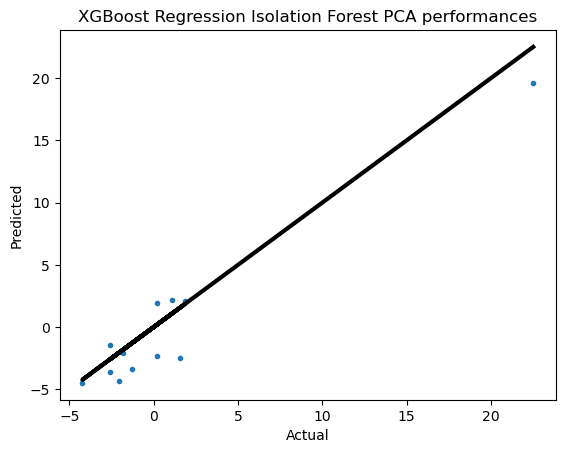

In [41]:
optim.plot()

In [42]:
# Add to dataset
stats[model_name] = xgb_regr_iso_pca

## Ridge Regression Pipeline

### Base Pipeline

In [43]:
optim = ModelOptimizer()
model_name = 'Ridge Regression'
ridge_regr = optim.full_pipeline(preprocessor,diamonds,'Ridge',model_name)

[I 2024-07-02 11:24:32,596] A new study created in memory with name: Diamonds Ridge
C:\Users\len\AppData\Local\Temp\ipykernel_16124\4189820891.py:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
C:\Users\len\AppData\Local\Temp\ipykernel_16124\4189820891.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
[I 2024-07-02 11:24:32,616] Trial 0 finished with value: 0.14022699286416856 and parameters: {'alpha': 0.008033025968754605, 'fit_intercept': False, 'solver': 'svd', 'tol': 0.00047098999740611733}. Best is trial 0 with value: 0.14022699286416856.
C:\Users\len\AppD

In [44]:
ridge_regr

,Ridge Regression
MAE,0.1305
R2,0.9681


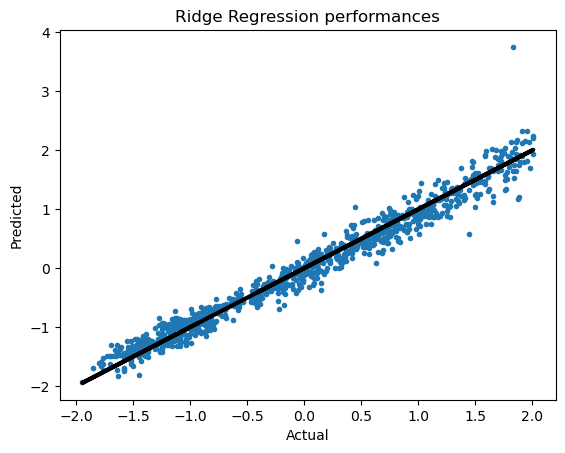

In [45]:
optim.plot()

In [46]:
# Add to dataset
stats[model_name] = ridge_regr

### Isolation Forest Pipeline

In [47]:
optim = ModelOptimizer()
model_name = 'Ridge Regression Isolation Forest'
ridge_regr_iso = optim.full_pipeline(preprocessor_iso,diamonds,'Ridge',model_name)

[I 2024-07-02 11:24:38,807] A new study created in memory with name: Diamonds Ridge
C:\Users\len\AppData\Local\Temp\ipykernel_16124\4189820891.py:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
C:\Users\len\AppData\Local\Temp\ipykernel_16124\4189820891.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
[I 2024-07-02 11:24:38,816] Trial 0 finished with value: 0.14438376029779804 and parameters: {'alpha': 0.05385802601844766, 'fit_intercept': True, 'solver': 'lsqr', 'tol': 0.0002543222118071877}. Best is trial 0 with value: 0.14438376029779804.
C:\Users\len\AppDat

In [48]:
ridge_regr_iso

,Ridge Regression Isolation Forest
MAE,0.1437
R2,0.9659


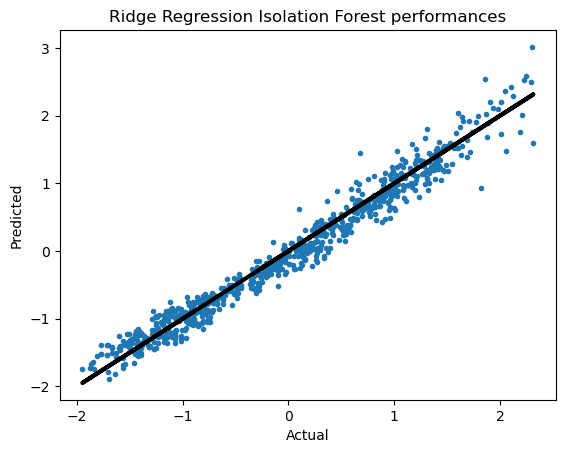

In [49]:
optim.plot()

In [50]:
# Add to dataset
stats[model_name] = ridge_regr_iso

### PCA Pipeline

In [51]:
optim = ModelOptimizer()
model_name = 'Ridge Regression PCA'
ridge_regr_pca = optim.full_pipeline(preprocessor_pca,diamonds,'Ridge',model_name)

[I 2024-07-02 11:24:41,785] A new study created in memory with name: Diamonds Ridge
C:\Users\len\AppData\Local\Temp\ipykernel_16124\4189820891.py:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
C:\Users\len\AppData\Local\Temp\ipykernel_16124\4189820891.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
[I 2024-07-02 11:24:41,792] Trial 0 finished with value: 0.41564508260986366 and parameters: {'alpha': 0.058467567069189846, 'fit_intercept': True, 'solver': 'lsqr', 'tol': 1.783991824350466e-05}. Best is trial 0 with value: 0.41564508260986366.
C:\Users\len\AppDa

In [52]:
ridge_regr_pca

,Ridge Regression PCA
MAE,0.382
R2,0.995


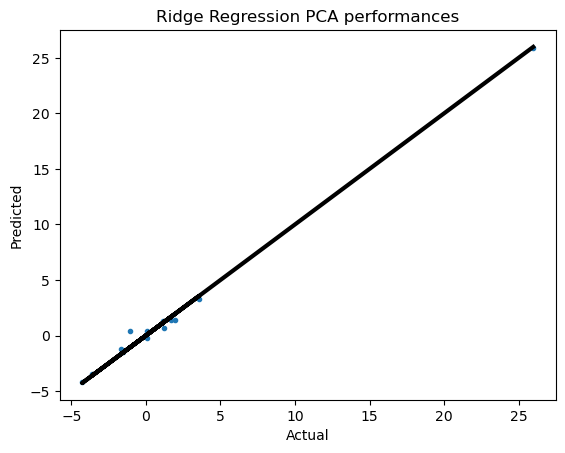

In [53]:
optim.plot()

In [54]:
# Add to dataset
stats[model_name] = ridge_regr_pca

### Isolation Forest and PCA Pipeline

In [55]:
optim = ModelOptimizer()
model_name = 'Ridge Regression Isolation Forest PCA'
ridge_regr_iso_pca = optim.full_pipeline(preprocessor_iso_pca,diamonds,'Ridge',model_name)

[I 2024-07-02 11:24:44,546] A new study created in memory with name: Diamonds Ridge
C:\Users\len\AppData\Local\Temp\ipykernel_16124\4189820891.py:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e2),
C:\Users\len\AppData\Local\Temp\ipykernel_16124\4189820891.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tol': trial.suggest_loguniform('tol', 1e-6, 1e-1)
[I 2024-07-02 11:24:44,548] Trial 0 finished with value: 0.4511050631870817 and parameters: {'alpha': 0.4743662228735008, 'fit_intercept': False, 'solver': 'lsqr', 'tol': 4.020745820129012e-06}. Best is trial 0 with value: 0.4511050631870817.
C:\Users\len\AppData\

In [56]:
ridge_regr_iso_pca

,Ridge Regression Isolation Forest PCA
MAE,0.4348
R2,0.9903


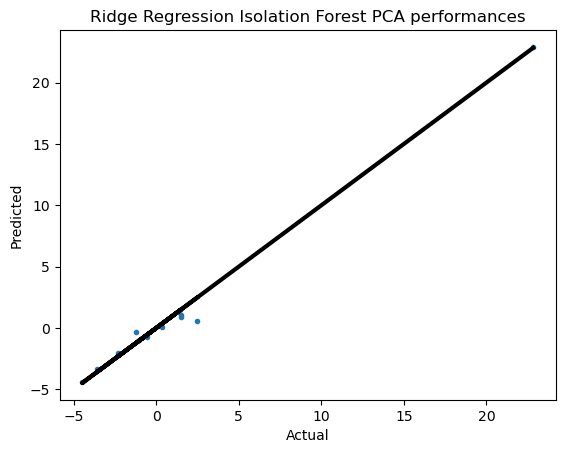

In [57]:
optim.plot()

In [58]:
# Add to dataset
stats[model_name] = ridge_regr_iso_pca

## Final Statistics

In [59]:
stats_final = stats.copy()
del stats_final['col']
stats_final = stats_final.T
stats_final

,MAE,R2
Linear Regression,0.1305,0.9681
Linear Regression Isolation Forest,0.1401,0.9670
Linear Regression PCA,0.3825,0.9950
Linear Regression Isolation Forest and PCA,0.2779,0.9973
XGBoost Regression,0.1123,0.9765
XGBoost Regression Isolation Forest,0.1328,0.9687
XGBoost Regression PCA,2.3494,0.6955
XGBoost Regression Isolation Forest PCA,1.6363,0.9112
Ridge Regression,0.1305,0.9681
Ridge Regression Isolation Forest,0.1437,0.9659


In [60]:
stats_final.to_csv('Model_statistics.csv')